In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# 학습 데이터와 테스트 데이터 읽기
train_file_path = '/content/train.csv'  # 학습 데이터 파일 경로
test_file_path = '/content/test.csv'      # 테스트 데이터 파일 경로
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# 결측값 처리
train_data.fillna('WT', inplace=True)
test_data.fillna('WT', inplace=True)

# 특징과 타겟 분리
X_train = train_data.drop(columns=['ID', 'SUBCLASS'])  # ID와 SUBCLASS 열 제거
y_train = train_data['SUBCLASS']

# 특징 인코딩: 'WT'는 0, 그 외는 첫 글자 + 컬럼명 조합으로 변환
def encode_feature(col):
    return col.apply(lambda x: '' if x == 'WT' else f"{x[0]}_{col.name}")

# 모든 특성에 대해 인코딩 적용
X_train_encoded = X_train.apply(encode_feature)
X_test_encoded = test_data.drop(columns=['ID']).apply(encode_feature)  # 테스트 데이터 인코딩

# 레이블 인코딩
le = LabelEncoder()
for c in X_train_encoded.columns:
    X_train_encoded[c] = le.fit_transform(X_train_encoded[c])

# 테스트 데이터에도 동일한 인코딩 적용
for c in X_test_encoded.columns:
    if c in le.classes_:
        X_test_encoded[c] = le.transform(X_test_encoded[c])
    else:
        X_test_encoded[c] = le.fit_transform(X_test_encoded[c])

# 레이블 인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y_train)

# 훈련 데이터와 검증 데이터 분리
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_encoded, y_encoded, test_size=0.2, random_state=42)

# NumPy 배열로 변환
X_train_final = X_train_final.values
X_val = X_val.values
X_test_encoded = X_test_encoded.values

# 모델 구성
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_final.shape[1],)),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le_y.classes_), activation='softmax')  # 클래스 수에 맞추어 출력 노드 수 설정
])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val),
          epochs=200, batch_size=32,
          callbacks=[early_stopping])

# 검증 데이터 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# 테스트 데이터 예측
test_predictions = model.predict(X_test_encoded)

# 예측 결과 변환
predicted_labels = le_y.inverse_transform(test_predictions.argmax(axis=1))

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('predictions_combined_data.csv', index=False)

print("Predictions saved to 'predictions_combined_data.csv'.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1269 - loss: 3.1852 - val_accuracy: 0.2627 - val_loss: 2.6081
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.3300 - loss: 2.3076 - val_accuracy: 0.2877 - val_loss: 2.3395
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.5059 - loss: 1.5872 - val_accuracy: 0.3022 - val_loss: 2.2999
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6572 - loss: 1.0505 - val_accuracy: 0.3038 - val_loss: 2.4230
Epoch 5/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7403 - loss: 0.7671 - val_accuracy: 0.3046 - val_loss: 2.6603
Epoch 6/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8010 - loss: 0.5951 - val_accuracy: 0.2933 - val_loss: 2.8113
Epoch 7/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8323 - loss: 0.5183 - val_accuracy: 0.2965 - val_loss: 2.9689
Epoch 8/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8594 - loss: 0.4128 - 

In [ ]:
results.SUBCLASS.value_counts()

,count
SUBCLASS,
STES,745
BRCA,503
KIPAN,204
COAD,153
THCA,123
GBMLGG,104
SKCM,93
PRAD,93
LGG,90


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# 학습 데이터와 테스트 데이터 읽기
train_file_path = '/content/train.csv'  # 학습 데이터 파일 경로
test_file_path = '/content/test.csv'      # 테스트 데이터 파일 경로
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# 결측값 처리
train_data.fillna('WT', inplace=True)
test_data.fillna('WT', inplace=True)

# 특징과 타겟 분리
X_train = train_data.drop(columns=['ID', 'SUBCLASS'])  # ID와 SUBCLASS 열 제거
y_train = train_data['SUBCLASS']

# 특징 인코딩: 'WT'는 0, 그 외는 첫 글자 + 컬럼명 조합으로 변환
def encode_feature(col):
    return col.apply(lambda x: '' if x == 'WT' else f"{x[0]}_{col.name}")

# 모든 특성에 대해 인코딩 적용
X_train_encoded = X_train.apply(encode_feature)
X_test_encoded = test_data.drop(columns=['ID']).apply(encode_feature)  # 테스트 데이터 인코딩

# 레이블 인코딩
le = LabelEncoder()
for c in X_train_encoded.columns:
    X_train_encoded[c] = le.fit_transform(X_train_encoded[c])

# 테스트 데이터에도 동일한 인코딩 적용
for c in X_test_encoded.columns:
    if c in le.classes_:
        X_test_encoded[c] = le.transform(X_test_encoded[c])
    else:
        X_test_encoded[c] = le.fit_transform(X_test_encoded[c])

# 레이블 인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y_train)

# 훈련 데이터와 검증 데이터 분리
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_encoded, y_encoded, test_size=0.2, random_state=42)

# NumPy 배열로 변환
X_train_final = X_train_final.values
X_val = X_val.values
X_test_encoded = X_test_encoded.values

# 모델 구성
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_final.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le_y.classes_), activation='softmax')  # 클래스 수에 맞추어 출력 노드 수 설정

])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val),
          epochs=200, batch_size=32,
          callbacks=[early_stopping])

# 검증 데이터 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# 테스트 데이터 예측
test_predictions = model.predict(X_test_encoded)

# 예측 결과 변환
predicted_labels = le_y.inverse_transform(test_predictions.argmax(axis=1))

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('p00001redictions_combined_data.csv', index=False)

print("Predictions saved to 'predictions_combined_data.csv'.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.0462 - loss: 3.6910 - val_accuracy: 0.0967 - val_loss: 3.1521
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0941 - loss: 3.2340 - val_accuracy: 0.1378 - val_loss: 3.0817
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1266 - loss: 3.0573 - val_accuracy: 0.1821 - val_loss: 3.0262
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1700 - loss: 2.9229 - val_accuracy: 0.2095 - val_loss: 2.9457
Epoch 5/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2223 - loss: 2.8218 - val_accuracy: 0.2385 - val_loss: 2.8510
Epoch 6/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2482 - loss: 2.6875 - val_accuracy: 0.2425 - val_loss: 2.7435
Epoch 7/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2966 - loss: 2.5203 - val_accuracy: 0.2434 - val_loss: 2.6473
Epoch 8/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.3156 - loss: 2.3662 - 

In [ ]:
results.SUBCLASS.value_counts()


,count
SUBCLASS,
BRCA,641
COAD,392
STES,350
KIPAN,249
GBMLGG,128
KIRC,113
SKCM,107
THCA,81
LGG,62


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.0570 - loss: 3.6941 - val_accuracy: 0.1297 - val_loss: 3.1535 - learning_rate: 1.0000e-04
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.1060 - loss: 3.2143 - val_accuracy: 0.1636 - val_loss: 3.0857 - learning_rate: 1.0000e-04
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.1396 - loss: 3.0595 - val_accuracy: 0.1821 - val_loss: 3.0273 - learning_rate: 1.0000e-04
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.1693 - loss: 2.9207 - val_accuracy: 0.2168 - val_loss: 2.9476 - learning_rate: 1.0000e-04
Epoch 5/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2216 - loss: 2.8005 - val_accuracy: 0.2248 - val_loss: 2.8488 - learning_rate: 1.0000e-04
Epoch 6/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.2646 - loss: 2.6403 - val_accuracy: 0.2409 - val_loss: 2.7296 - learning_rate: 1.0000e-04
Epoch 7/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/ste

In [ ]:
results.SUBCLASS.value_counts()

,count
SUBCLASS,
BRCA,609
COAD,412
KIPAN,306
STES,251
GBMLGG,143
OV,118
UCEC,114
SKCM,101
THCA,90


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 로드 및 전처리
train_file_path = '/content/train.csv'
train_data = pd.read_csv(train_file_path)
train_data.fillna('WT', inplace=True)

X = train_data.drop(columns=['ID', 'SUBCLASS'])
y = train_data['SUBCLASS']

# 인코딩
def encode_feature(col):
    return col.apply(lambda x: '' if x == 'WT' else f"{x[0]}_{col.name}")

X_encoded = X.apply(encode_feature)
le = LabelEncoder()
for c in X_encoded.columns:
    X_encoded[c] = le.fit_transform(X_encoded[c])

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 학습 및 검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# 모델 구성 (더 복잡한 구조)
model = keras.Sequential([
    layers.Dense(512, activation='leaky_relu', input_shape=(X_train.shape[1],)),  # Leaky ReLU 사용
    layers.Dropout(0.5),
    layers.Dense(256, activation='leaky_relu'),  # Leaky ReLU 사용
    layers.Dropout(0.5),
    layers.Dense(128, activation='leaky_relu'),  # Leaky ReLU 사용
    layers.Dense(len(le_y.classes_), activation='softmax')  # 소프트맥스 활성화
])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=200, batch_size=32,
          callbacks=[early_stopping])

# 검증 데이터 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.1350 - loss: 3.4621 - val_accuracy: 0.2804 - val_loss: 2.4879
Epoch 2/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3871 - loss: 2.0746 - val_accuracy: 0.3006 - val_loss: 2.4108
Epoch 3/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5169 - loss: 1.5775 - val_accuracy: 0.3038 - val_loss: 2.3729
Epoch 4/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6438 - loss: 1.1354 - val_accuracy: 0.3086 - val_loss: 2.6019
Epoch 5/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7133 - loss: 0.9385 - val_accuracy: 0.3086 - val_loss: 3.0874
Epoch 6/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7679 - loss: 0.7019 - val_accuracy: 0.2990 - val_loss: 3.1983
Epoch 7/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8208 - loss: 0.5362 - val_accuracy: 0.3006 - val_loss: 3.6485
Epoch 8/200
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8146 - loss: 0.5323 - 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# 학습 데이터와 테스트 데이터 읽기
train_file_path = '/content/train.csv'  # 학습 데이터 파일 경로
test_file_path = '/content/test.csv'      # 테스트 데이터 파일 경로
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# 결측값 처리
train_data.fillna('WT', inplace=True)
test_data.fillna('WT', inplace=True)

test_data['SUBCLASS'] = None
# 학습 데이터와 테스트 데이터 결합
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# 특징과 타겟 분리
#X_train = train_data.drop(columns=['ID', 'SUBCLASS'])  # ID와 SUBCLASS 열 제거
#y_train = train_data['SUBCLASS']
# 특징과 타겟 분리
X = combined_data.drop(columns=['ID', 'SUBCLASS'])
y = combined_data['SUBCLASS']

# 특징 인코딩: 'WT'는 0, 그 외는 첫 글자 + 컬럼명 조합으로 변환
def encode_feature(col):
    return col.apply(lambda x: '' if x == 'WT' else f"{str(x)[0]}_{col.name}")

# 모든 특성에 대해 인코딩 적용
X_encoded = X_encoded.apply(encode_feature)

# 레이블 인코딩
le = LabelEncoder()
for c in X_encoded.columns:
    X_encoded[c] = le.fit_transform(X_encoded[c])


# 레이블 인코딩
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y_train)



# 학습 데이터와 테스트 데이터 분리
y_encoded_full = pd.Series([None] * len(combined_data), index=combined_data.index)
y_encoded_full.iloc[:len(y_encoded)] = y_encoded

# 학습/검증 데이터 분리
X_train_final, X_val, y_train_final, y_val = train_test_split(X_encoded[:len(y_encoded)], y_encoded, test_size=0.2, random_state=42)



# 훈련 데이터와 검증 데이터 분리
#X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_encoded, y_encoded, test_size=0.2, random_state=42)

# NumPy 배열로 변환
X_train_final = X_train_final.values
X_val = X_val.values

# 모델 구성
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_final.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le_y.classes_), activation='softmax')  # 클래스 수에 맞추어 출력 노드 수 설정

])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 학습
model.fit(X_train_final, y_train_final, validation_data=(X_val, y_val),
          epochs=200, batch_size=32,
          callbacks=[early_stopping])

# 검증 데이터 평가
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

# 테스트 데이터 예측

# 테스트 데이터 예측
X_test_encoded = X_encoded[len(y_encoded):]
predictions = model.predict(X_test_encoded)

#test_predictions = model.predict(X_test_encoded)

# 예측 결과 변환
predicted_classes = predictions.argmax(axis=1)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.0773 - loss: 3.2765 - val_accuracy: 0.1351 - val_loss: 3.1553
Epoch 2/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.1372 - loss: 3.0655 - val_accuracy: 0.1280 - val_loss: 3.1252
Epoch 3/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.1868 - loss: 2.9129 - val_accuracy: 0.1139 - val_loss: 3.1216
Epoch 4/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.2332 - loss: 2.6815 - val_accuracy: 0.1139 - val_loss: 3.1747
Epoch 5/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.3536 - loss: 2.3018 - val_accuracy: 0.1018 - val_loss: 3.3453
Epoch 6/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4680 - loss: 1.9248 - val_accuracy: 0.0847 - val_loss: 3.6185
Epoch 7/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5686 - loss: 1.6077 - val_accuracy: 0.0786 - val_loss: 3.9390
Epoch 8/200
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.6607 - loss: 1.2901 - 

ValueError: y contains previously unseen labels: [10 11 15 19 20 21 23 25]

In [ ]:

# 레이블 인코딩된 클래스를 원래 클래스 이름으로 변환
predicted_labels = le_y.inverse_transform(predicted_classes)


# 예측 결과 변환
#predicted_labels = le_y.inverse_transform(test_predictions.argmax(axis=1))

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('combined_p00001redictions_combined_data.csv', index=False)

print("Predictions saved to 'predictions_combined_data.csv'.")

ValueError: array length 1241 does not match index length 2546

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE  # SMOTE 사용을 위한 라이브러리 추가

# 학습 데이터 읽기
train_file_path = '/content/train.csv'  # 학습 데이터 파일 경로
train_data = pd.read_csv(train_file_path)

# 결측값 처리
train_data.fillna('WT', inplace=True)

# 테스트 데이터 읽기
test_file_path = '/content/test.csv'  # 테스트 데이터 파일 경로
test_data = pd.read_csv(test_file_path)

# 결측값 처리
test_data.fillna('WT', inplace=True)

# 테스트 데이터에 SUBCLASS 열 추가 (NaN으로 설정)
test_data['SUBCLASS'] = None

# 학습 데이터와 테스트 데이터 결합
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# 특징과 타겟 분리
X = combined_data.drop(columns=['ID', 'SUBCLASS'])  # ID와 SUBCLASS 열 제거
y = combined_data['SUBCLASS']

# 특징 인코딩: 'WT'는 0, 그 외는 1로 변환
X_encoded = X.apply(lambda col: col.map(lambda x: 0 if x == 'WT' else 1))

# 레이블 인코딩 (학습 데이터에만 적용)
le = LabelEncoder()
y_encoded = le.fit_transform(y.dropna())  # NaN을 제외하고 인코딩

# 학습 데이터와 테스트 데이터 분리
y_encoded_full = pd.Series([None] * len(combined_data), index=combined_data.index)  # 초기화
y_encoded_full.iloc[:len(y_encoded)] = y_encoded  # 학습 데이터에 대해서만 값 설정

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_encoded[:len(y_encoded)], y_encoded, test_size=0.2, random_state=42)

# 모델 구성
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),  # 드롭아웃 비율 조정
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # 드롭아웃 비율 조정
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')  # 클래스 수에 맞추어 출력 노드 수 설정
])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

# 테스트 데이터 예측
X_test_encoded = X_encoded[len(y_encoded):]  # 테스트 데이터 부분

predictions = model.predict(X_test_encoded)

# 예측 결과 변환
predicted_classes = predictions.argmax(axis=1)

# 레이블 인코딩된 클래스를 원래 클래스 이름으로 변환
predicted_labels = le.inverse_transform(predicted_classes)

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('maybe_predictions_no_scaler.csv', index=False)

print("Predictions saved to 'predictions_no_scaler.csv'.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.1679 - loss: 2.9185 - val_accuracy: 0.2981 - val_loss: 2.3803
Epoch 2/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.5024 - loss: 1.5784 - val_accuracy: 0.3521 - val_loss: 2.1146
Epoch 3/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7476 - loss: 0.7406 - val_accuracy: 0.3288 - val_loss: 2.4988
Epoch 4/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8422 - loss: 0.4149 - val_accuracy: 0.3175 - val_loss: 2.8838
Epoch 5/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8870 - loss: 0.3416 - val_accuracy: 0.3151 - val_loss: 2.9985
Epoch 6/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.8968 - loss: 0.2448 - val_accuracy: 0.3159 - val_loss: 3.3755
Epoch 7/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9113 - loss: 0.2029 - val_accuracy: 0.2917 - val_loss: 3.5270
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Predictions saved to 'predictions_no_scaler.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# 학습 데이터 읽기
train_file_path = '/content/train.csv'  # 학습 데이터 파일 경로
train_data = pd.read_csv(train_file_path)

# 결측값 처리
train_data.fillna('WT', inplace=True)

# 테스트 데이터 읽기
test_file_path = '/content/test.csv'  # 테스트 데이터 파일 경로
test_data = pd.read_csv(test_file_path)

# 결측값 처리
test_data.fillna('WT', inplace=True)

# 테스트 데이터에 SUBCLASS 열 추가 (NaN으로 설정)
test_data['SUBCLASS'] = None

# 학습 데이터와 테스트 데이터 결합
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# 특징과 타겟 분리
X = combined_data.drop(columns=['ID', 'SUBCLASS'])  # ID와 SUBCLASS 열 제거
y = combined_data['SUBCLASS']

# 특징 인코딩: 'WT'는 0, 그 외는 1로 변환
X_encoded = X.apply(lambda col: col.map(lambda x: 0 if x == 'WT' else 1))

# 레이블 인코딩 (학습 데이터에만 적용)
le = LabelEncoder()
y_encoded = le.fit_transform(y.dropna())  # NaN을 제외하고 인코딩

# 학습 데이터와 테스트 데이터 분리
y_encoded_full = pd.Series([None] * len(combined_data), index=combined_data.index)  # 초기화
y_encoded_full.iloc[:len(y_encoded)] = y_encoded  # 학습 데이터에 대해서만 값 설정

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_encoded[:len(y_encoded)], y_encoded, test_size=0.2, random_state=42)

# 모델 구성
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),  # 드롭아웃 비율 조정
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # 드롭아웃 비율 조정
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')  # 클래스 수에 맞추어 출력 노드 수 설정
])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

# 테스트 데이터 예측
X_test_encoded = X_encoded[len(y_encoded):]  # 테스트 데이터 부분

predictions = model.predict(X_test_encoded)

# 예측 결과 변환
predicted_classes = predictions.argmax(axis=1)

# 레이블 인코딩된 클래스를 원래 클래스 이름으로 변환
predicted_labels = le.inverse_transform(predicted_classes)

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('2maybe_predictions_no_scaler.csv', index=False)

print("Predictions saved to 'predictions_no_scaler.csv'.")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.1703 - loss: 2.9494 - val_accuracy: 0.3376 - val_loss: 2.1766
Epoch 2/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4967 - loss: 1.5575 - val_accuracy: 0.3497 - val_loss: 2.1293
Epoch 3/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7560 - loss: 0.7552 - val_accuracy: 0.3263 - val_loss: 2.6459
Epoch 4/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8534 - loss: 0.4035 - val_accuracy: 0.3094 - val_loss: 3.0063
Epoch 5/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8837 - loss: 0.3033 - val_accuracy: 0.3159 - val_loss: 3.3397
Epoch 6/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8824 - loss: 0.2844 - val_accuracy: 0.3070 - val_loss: 3.3938
Epoch 7/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9030 - loss: 0.2517 - val_accuracy: 0.3022 - val_loss: 3.2401
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predictions saved to 'predictions_no_scaler.csv'.


In [ ]:
import numpy as np

# 1. 초기 학습 단계는 그대로 유지

# 2. 테스트 데이터에 대한 예측
predictions = model.predict(X_test_encoded)
predicted_classes = predictions.argmax(axis=1)

# 예측의 신뢰도 확인 (예: 확률이 0.9 이상인 경우)
confidence_threshold = 0.9
confident_predictions = np.max(predictions, axis=1) > confidence_threshold
confident_indices = np.where(confident_predictions)[0]

# 신뢰도 높은 예측 데이터만 선택
confident_X_test = X_test_encoded.iloc[confident_indices]
confident_y_test = predicted_classes[confident_indices]

# 3. 확장된 학습 데이터 구성
X_extended = pd.concat([X_train, confident_X_test])
y_extended = np.concatenate([y_train, confident_y_test])

# 4. 확장된 데이터로 모델 재학습
model.fit(X_extended, y_extended, validation_data=(X_val, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7333 - loss: 0.8522 - val_accuracy: 0.3151 - val_loss: 2.7421
Epoch 2/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8464 - loss: 0.5144 - val_accuracy: 0.3481 - val_loss: 2.6908
Epoch 3/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.8785 - loss: 0.2918 - val_accuracy: 0.3046 - val_loss: 2.8544
Epoch 4/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9074 - loss: 0.2249 - val_accuracy: 0.2901 - val_loss: 3.2996
Epoch 5/100
323/323 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9058 - loss: 0.2035 - val_accuracy: 0.3022 - val_loss: 3.2881


In [ ]:

predictions = model.predict(X_test_encoded)

# 예측 결과 변환
predicted_classes = predictions.argmax(axis=1)

# 레이블 인코딩된 클래스를 원래 클래스 이름으로 변환
predicted_labels = le.inverse_transform(predicted_classes)

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('23maybe_predictions_no_scaler.csv', index=False)

print("Predictions saved to 'predictions_no_scaler.csv'.")


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Predictions saved to 'predictions_no_scaler.csv'.


In [ ]:
results.SUBCLASS.value_counts()

,count
SUBCLASS,
COAD,366
BRCA,339
UCEC,338
STES,276
THCA,174
KIPAN,126
GBMLGG,123
PRAD,106
CESC,102


In [ ]:
len(confident_indices)

198

In [ ]:
df = pd.read_csv('/content/train.csv')
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix

In [ ]:
# Feature와 타겟 분리
X = df.drop(columns=['SUBCLASS'])
y = df['SUBCLASS']

# One-hot 인코딩 적용 (또는 필요한 다른 변환)

encoder = OneHotEncoder(sparse_output=True) # sparse argument -> sparse_output
X_sparse = encoder.fit_transform(X)

# 스파스 매트릭스 출력
X_sparse_csr = csr_matrix(X_sparse)


In [ ]:
# y (타겟) 레이블 인코딩
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Keras 모델 정의
model = Sequential()
model.add(Dense(512, input_shape=(X_sparse.shape[1],), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# 모델 컴파일
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(X_sparse, y_encoded, epochs=10, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 109153280 elements. This may consume a large amount of memory.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.0810 - loss: 3.5588 - val_accuracy: 0.0870 - val_loss: 3.2611
Epoch 2/10
 19/155 ━━━━━━━━━━━━━━━━━━━━ 2:44 1s/step - accuracy: 0.0789 - loss: 3.1882

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# train_sample.csv 파일을 읽어옵니다.
data =  pd.read_csv('/content/train.csv')

# 모든 컬럼에 대해 LabelEncoder를 적용합니다.
for col in data.columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# input_data를 숫자형으로 변환된 데이터로 설정합니다.
input_data = data.values

# input_data의 shape을 출력합니다.
print(input_data.shape)

(6201, 4386)


In [ ]:
from tensorflow import keras

# 인코더
encoder = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(input_data.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu')  # 잠재 공간 차원: 32
])

# 디코더
decoder = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(32,)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(input_data.shape[1], activation='sigmoid')  # 출력층 차원: 4386
])

# 자동 인코더 모델
autoencoder = keras.Sequential([encoder, decoder])

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 학습
autoencoder.fit(input_data, input_data, epochs=10, batch_size=32)

# 차원 축소된 데이터 얻기
encoded_data = encoder.predict(input_data)

# encoded_data의 shape을 출력합니다.
print(encoded_data.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 6949.5786
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 6948.3232
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6914.9170
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6971.7559
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6984.0747
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6988.0566
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6993.1606
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6971.2944
Epoch 9/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6953.9136
Epoch 10/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6952.7544
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(6201, 32)


In [ ]:
encoded_data

array([[   0.     ,  175.43918, 1423.6301 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,  181.21515, 1417.5712 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,  174.97366, 1393.9761 , ...,    0.     ,    0.     ,
           0.     ],
       ...,
       [   0.     ,  277.4949 , 1607.2465 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,  274.60184, 1613.1019 , ...,    0.     ,    0.     ,
           0.     ],
       [   0.     ,  269.5323 , 1591.017  , ...,    0.     ,    0.     ,
           0.     ]], dtype=float32)

In [294]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

# CSV 데이터 로드
df =  pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')



In [ ]:
df.shape

(6201, 4386)

In [ ]:
df_test.shape

(2546, 4385)

In [295]:
df_test.drop(columns='ID', inplace=True)

cdf = df_test.apply(lambda x : x!='WT').agg(sum).reset_index(name='count')  #.sort_values(by='count', ascending=False)
to_remove = cdf[cdf['count'] == 0 ]['index'].values
df.drop(columns = to_remove, axis=1, inplace=True)
df_test.drop(columns = to_remove, axis=1, inplace=True)

data = df.drop(columns=['ID', 'SUBCLASS'])
disease_list = df.SUBCLASS.unique()
df.shape

<ipython-input-295-8fba141ca3c2>:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrame.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdf = df_test.apply(lambda x : x!='WT').agg(sum).reset_index(name='count')  #.sort_values(by='count', ascending=False)


(6201, 4360)

In [ ]:
data

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2,R895R,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6197,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
6198,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,T181S,WT
6199,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [ ]:
df_test

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,WT,WT,WT,WT,WT,L217I,P221P P251P,R5M,G606D,I248Nfs,...,S2049Vfs S1909Vfs,L232R,WT,WT,L305L,WT,N252I N251I,G679V,WT,WT
2544,WT,WT,WT,WT,WT,WT,WT,WT,R1517H,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [ ]:
X = df.drop(columns=['ID','SUBCLASS'])
y = df['SUBCLASS']

# 타겟 레이블 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


from sklearn.decomposition import PCA
import numpy as np

# PCA 적용하여 피처 수를 4096개로 줄이기
pca = PCA(n_components=4096)
X_pca = pca.fit_transform(X_encoded)

# 64x64로 reshape (4096 = 64x64)
X_reshaped = X_pca.reshape(-1, 64, 64, 1)

# CNN 모델 적용
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_reshaped, y_encoded, epochs=10, batch_size=32, validation_split=0.2)



KeyboardInterrupt: 

In [ ]:
X_train

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
286,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1820,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4384,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
y

array([21,  7, 22, ...,  8,  8, 25])

AttributeError: 'numpy.ndarray' object has no attribute 'groupby'

In [ ]:
df_test

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,WT,WT,WT,WT,WT,L217I,P221P P251P,R5M,G606D,I248Nfs,...,S2049Vfs S1909Vfs,L232R,WT,WT,L305L,WT,N252I N251I,G679V,WT,WT
2544,WT,WT,WT,WT,WT,WT,WT,WT,R1517H,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

# 학습 데이터 읽기
train_file_path = '/content/train.csv'  # 학습 데이터 파일 경로
train_data = pd.read_csv(train_file_path)

# 결측값 처리
train_data.fillna('WT', inplace=True)

# 테스트 데이터 읽기
test_file_path = '/content/test.csv'  # 테스트 데이터 파일 경로
test_data = pd.read_csv(test_file_path)

# 결측값 처리
test_data.fillna('WT', inplace=True)

# 테스트 데이터에 SUBCLASS 열 추가 (NaN으로 설정)
test_data['SUBCLASS'] = None

# 학습 데이터와 테스트 데이터 결합
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# 특징과 타겟 분리
X = combined_data.drop(columns=['ID', 'SUBCLASS'])  # ID와 SUBCLASS 열 제거
y = combined_data['SUBCLASS']

# 특징 인코딩: 'WT'는 0, 그 외는 1로 변환
X_encoded = X.apply(lambda col: col.map(lambda x: 0 if x == 'WT' else 1))

# 레이블 인코딩 (학습 데이터에만 적용)
le = LabelEncoder()
y_encoded = le.fit_transform(y.dropna())  # NaN을 제외하고 인코딩

# 학습 데이터와 테스트 데이터 분리
y_encoded_full = pd.Series([None] * len(combined_data), index=combined_data.index)  # 초기화
y_encoded_full.iloc[:len(y_encoded)] = y_encoded  # 학습 데이터에 대해서만 값 설정

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_encoded[:len(y_encoded)], y_encoded, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)



In [76]:
df=train_data.copy()
df_test=test_data.copy()
cdf = df_test.apply(lambda x : x!='WT').agg(sum).reset_index(name='count')  #.sort_values(by='count', ascending=False)
to_remove = cdf[cdf['count'] == 0 ]['index'].values
df.drop(columns = to_remove, axis=1, inplace=True)
df_test.drop(columns = to_remove, axis=1, inplace=True)
df.shape
data = df.drop(columns=['ID', 'SUBCLASS'])
disease_list = df.SUBCLASS.unique()


<ipython-input-76-72a783cf570e>:3: FutureWarning: The provided callable <built-in function sum> is currently using DataFrame.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cdf = df_test.apply(lambda x : x!='WT').agg(sum).reset_index(name='count')  #.sort_values(by='count', ascending=False)


In [77]:
data = data.applymap(lambda x : 0 if x=='WT'  else 1)

<ipython-input-77-a0f4f770f5dc>:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x : 0 if x=='WT'  else 1)


In [78]:
data['SUBCLASS'] = df['SUBCLASS']

In [79]:
df_cat_data = data.copy()
df_cat_data['SUBCLASS'].map({'PRAD': 1, 'LUAD': 2, 'BRCA': 3, 'KIRC': 4, 'COAD': 5}).dropna()

,SUBCLASS
3,4.0
6,3.0
12,4.0
18,3.0
19,1.0
...,...
6187,5.0
6188,1.0
6193,5.0
6196,2.0


In [80]:
df_pca = data.copy()
df_pca = df_pca.drop(['SUBCLASS'], axis=1)
df_pca.head()

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
x_pca = df_pca.values

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(x_pca)
X_Scaled

array([[-0.15636715, -0.08453601, -0.06362332, ..., -0.09801016,
        -0.07534115, -0.08257899],
       [-0.15636715, -0.08453601, -0.06362332, ..., -0.09801016,
        -0.07534115, -0.08257899],
       [ 6.39520513, -0.08453601, -0.06362332, ..., -0.09801016,
        -0.07534115, -0.08257899],
       ...,
       [-0.15636715, -0.08453601, -0.06362332, ..., -0.09801016,
        13.27295855, -0.08257899],
       [-0.15636715, -0.08453601, -0.06362332, ..., -0.09801016,
        -0.07534115, -0.08257899],
       [-0.15636715, -0.08453601, -0.06362332, ..., -0.09801016,
        -0.07534115, -0.08257899]])

In [83]:
from sklearn.decomposition import PCA
pca_with_2=PCA(n_components=2)

In [84]:
#Perform fit transform on the scaled data
X_pca_with_2 = pca_with_2.fit_transform(X_Scaled)
X_pca_with_2.shape


(6201, 2)

In [85]:
X_pca_with_2

array([[-1.74846564,  0.20962329],
       [-3.35439218,  0.29539616],
       [12.47667404, -3.98259365],
       ...,
       [-3.49647614, -0.11526699],
       [-4.55584867, -0.04099931],
       [ 1.6020027 , -1.50950344]])

In [87]:
# Put the data back on the 2 columns defined
df_pca = pd.DataFrame(X_pca_with_2)
df_pca.columns = ['pca1','pca2']

# Add the convereted categorical data for
df_pca['cancer_type']=df_cat_data['SUBCLASS']
df_pca

,pca1,pca2,cancer_type
0,-1.748466,0.209623,KIPAN
1,-3.354392,0.295396,SARC
2,12.476674,-3.982594,SKCM
3,-4.703971,-0.054255,KIRC
4,-0.134409,0.479708,GBMLGG
...,...,...,...
6196,0.571307,-0.530800,LUAD
6197,-4.216258,0.135419,LGG
6198,-3.496476,-0.115267,COAD
6199,-4.555849,-0.040999,TGCT


<Axes: xlabel='pca1', ylabel='pca2'>

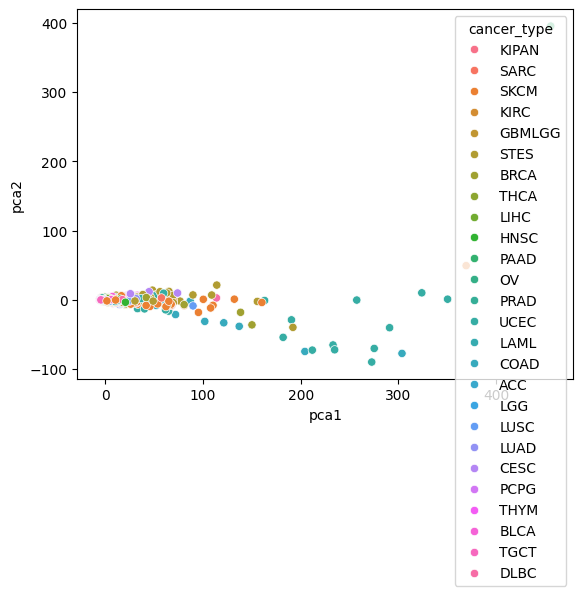

In [88]:
import seaborn as sns
# Present the data on the 5 clusters using seaborn maps
sns.scatterplot(x='pca1',y='pca2', hue = 'cancer_type',data=df_pca)

In [89]:
pca_with_995=PCA(.995)
X_pca_with_995 = pca_with_995.fit_transform(x_pca)
X_pca_with_995.shape
X_pca_with_995


array([[-1.75722138e-01, -7.05908697e-02, -2.26061221e-01, ...,
        -4.77605160e-03, -4.43872983e-02, -3.81264656e-03],
       [-3.93391090e-01,  1.45496885e-01,  6.41445429e-01, ...,
        -2.36675763e-02,  1.16457188e-02, -2.69455941e-02],
       [ 1.93371382e+00,  1.18618310e+00, -5.80515672e-01, ...,
        -1.24636595e-02,  1.30505429e-02,  2.21557795e-03],
       ...,
       [-3.33809669e-01, -8.91778699e-02, -1.44948668e-01, ...,
         1.53732744e-02, -5.19589926e-03,  1.90424649e-03],
       [-5.82295983e-01, -1.77232432e-01, -2.40590455e-01, ...,
         3.48696738e-02, -2.26515044e-02, -2.61061442e-02],
       [ 4.76291644e-01,  5.38206689e-01, -3.48909151e-01, ...,
        -3.05906263e-02, -1.95435203e-02, -1.90118592e-03]])

In [91]:
df_pca_995 = pd.DataFrame(X_pca_with_995)
df_pca_995['cancer_type']=df_cat_data['SUBCLASS']
df_pca_995

,0,1,2,3,4,5,6,7,8,9,...,3121,3122,3123,3124,3125,3126,3127,3128,3129,cancer_type
0,-0.175722,-0.070591,-0.226061,-0.178046,-0.119640,-0.118142,-0.033377,-0.116247,-0.085214,-0.096149,...,-0.026090,0.026898,-0.013014,-0.034947,0.015718,-0.014390,-0.004776,-0.044387,-0.003813,KIPAN
1,-0.393391,0.145497,0.641445,0.370048,0.279742,-0.045048,-0.131315,-0.036564,0.111403,-0.034038,...,-0.000884,-0.029122,0.020512,-0.018992,-0.022766,0.041715,-0.023668,0.011646,-0.026946,SARC
2,1.933714,1.186183,-0.580516,-0.625315,0.799701,-0.266794,-0.084568,-0.285990,-0.733198,-0.148124,...,-0.003945,-0.005466,0.014625,0.012192,0.002059,-0.010440,-0.012464,0.013051,0.002216,SKCM
3,-0.539272,-0.114286,-0.239821,-0.152323,0.104585,0.000955,0.025950,-0.044751,-0.100433,-0.041846,...,-0.000737,-0.017014,-0.009978,0.001945,-0.008543,0.003850,0.032114,0.023780,0.002037,KIRC
4,0.037052,0.169661,0.626500,0.245074,0.049416,0.052880,0.026275,0.046006,-0.119296,0.001930,...,-0.018935,0.019119,0.004249,-0.002710,-0.002888,0.006733,-0.014593,0.016910,-0.010843,GBMLGG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0.331011,0.350175,-0.080774,-0.323728,-0.263755,0.008234,-0.146025,0.025881,-0.182427,-0.012917,...,-0.018242,-0.023173,-0.015691,0.004275,0.041330,0.013785,-0.005790,-0.023394,-0.005477,LUAD
6197,-0.438786,0.036468,-0.276976,-0.163530,-0.104391,-0.030795,-0.033689,0.113696,-0.142886,0.006723,...,-0.005268,-0.000355,0.009014,0.029642,-0.005811,-0.041785,0.013449,-0.004010,0.010413,LGG
6198,-0.333810,-0.089178,-0.144949,-0.182894,0.005439,-0.009797,-0.040375,0.032136,0.066605,-0.035621,...,0.007239,-0.026054,0.049502,-0.020353,-0.050717,0.016702,0.015373,-0.005196,0.001904,COAD
6199,-0.582296,-0.177232,-0.240590,-0.087030,0.037314,0.044894,-0.058359,-0.017035,-0.007414,0.030145,...,0.040750,-0.040012,0.051316,0.014404,-0.003824,-0.007532,0.034870,-0.022652,-0.026106,TGCT


<Axes: xlabel='0', ylabel='1'>

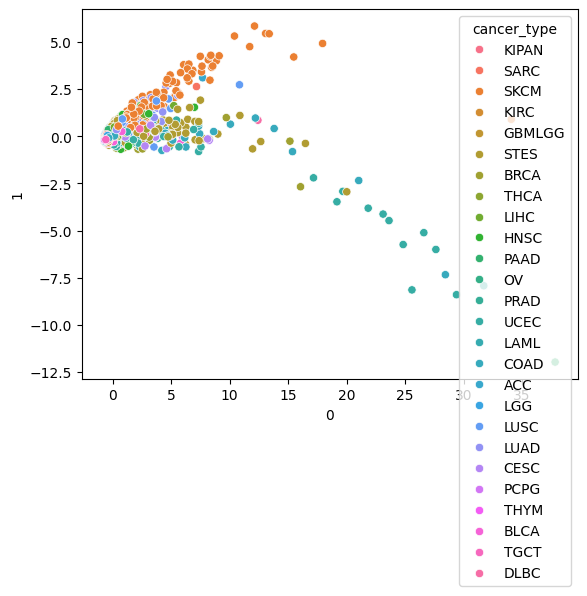

In [92]:
sns.scatterplot(x=0,y=1,hue = 'cancer_type', data=df_pca_995)

In [94]:
df_tsne_data = data.copy()
non_numeric = ['SUBCLASS']
df_tsne_data = df_tsne_data.drop(non_numeric, axis=1)
df_tsne_data

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
#import T-SNE from sklearn
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)
tnse_features = m.fit_transform(df_tsne_data)
tnse_features[1:4,:]

array([[ -7.9540186 ,  10.883754  ],
       [  2.4152226 , -13.758635  ],
       [-13.886175  ,   0.07929782]], dtype=float32)

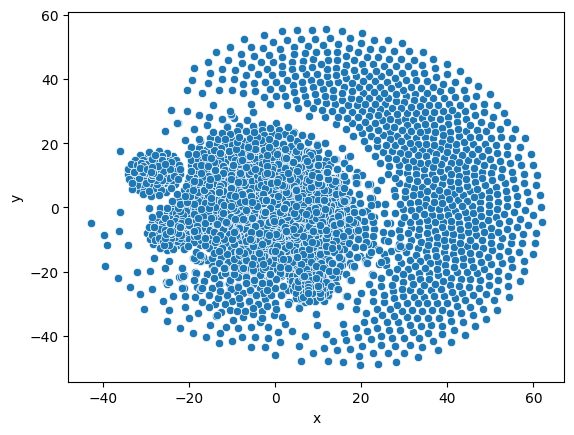

In [97]:
df_tsne_data['x'] = tnse_features[:,0]
df_tsne_data['y'] = tnse_features[:,1]

import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x='x',y='y',data=df_tsne_data)
plt.show()

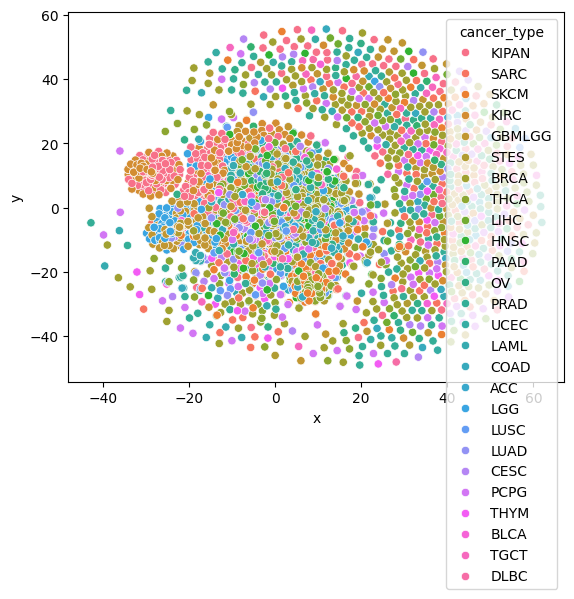

In [98]:
df_tsne_data['cancer_type']=df_cat_data['SUBCLASS']
sns.scatterplot(x='x',y='y',hue = 'cancer_type', data=df_tsne_data)
plt.show()

In [102]:
from sklearn.cluster import KMeans
clusters_995 = KMeans(5, n_init = 5)
clusters_995.fit(X_pca_with_995)
clusters_995.labels_

array([3, 3, 1, ..., 3, 3, 1], dtype=int32)

In [105]:
data.SUBCLASS.values

array(['KIPAN', 'SARC', 'SKCM', ..., 'COAD', 'TGCT', 'SKCM'], dtype=object)

In [106]:
pca_with_995_data_frame = pd.DataFrame(data=X_pca_with_995)
pca_with_995_data_frame.head()
pca_with_995_data_frame['Cls_label'] = clusters.labels_
pca_with_995_data_frame['given_cancer_type'] = data.SUBCLASS.values

In [107]:
pca_with_995_data_frame.shape

(6201, 3132)

In [108]:
brca_995 = pca_with_995_data_frame.groupby('given_cancer_type').get_group('BRCA')
brca_995.Cls_label.value_counts()

,count
Cls_label,
0,774
4,10
3,2


In [109]:
luad_995 = pca_with_995_data_frame.groupby('given_cancer_type').get_group('LUAD')
luad_995.Cls_label.value_counts()

,count
Cls_label,
0,172
4,12


In [110]:
coad_995 = pca_with_995_data_frame.groupby('given_cancer_type').get_group('COAD')
coad_995.Cls_label.value_counts()

,count
Cls_label,
0,195
4,22
3,4
1,2


In [111]:
prad_995 = pca_with_995_data_frame.groupby('given_cancer_type').get_group('PRAD')
prad_995.Cls_label.value_counts()

,count
Cls_label,
0,265
4,1


In [112]:
kirc_995 = pca_with_995_data_frame.groupby('given_cancer_type').get_group('KIRC')
kirc_995.Cls_label.value_counts()

,count
Cls_label,
0,334


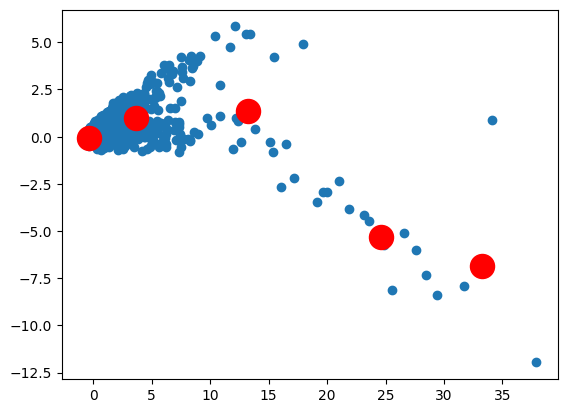

In [113]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_pca_with_995)
plt.scatter(X_pca_with_995[:,0], X_pca_with_995[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [114]:
x_lda

NameError: name 'x_lda' is not defined

In [116]:

df_lda = data.drop(['SUBCLASS'], axis=1)
x_lda = df_lda
x_lda

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
y_lda = data['SUBCLASS']
y_lda.values

array(['KIPAN', 'SARC', 'SKCM', ..., 'COAD', 'TGCT', 'SKCM'], dtype=object)

In [335]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
x_r2 = lda.fit(x_lda,y_lda).transform(x_lda)

In [336]:
lda.explained_variance_ratio_


array([0.12803603, 0.09279101])

In [337]:
x_r3 = pd.DataFrame(data=x_r2)
x_r3['y']=y_lda
x_r3

,0,1,y
0,1.376800,0.413193,KIPAN
1,-2.346093,-0.129749,SARC
2,2.567573,12.976111,SKCM
3,-0.542099,1.545138,KIRC
4,-1.767425,0.439230,GBMLGG
...,...,...,...
6196,0.382200,0.583005,LUAD
6197,-1.388121,0.538015,LGG
6198,-1.637096,-0.041651,COAD
6199,-0.146702,0.761188,TGCT


<Axes: xlabel='0', ylabel='1'>

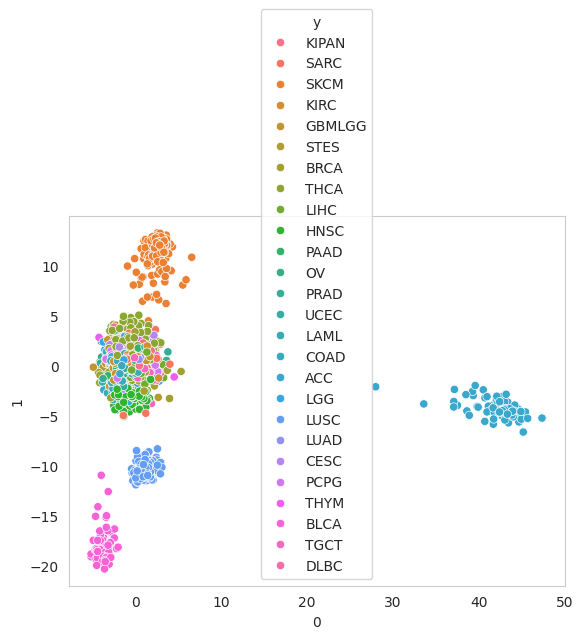

In [338]:
sns.scatterplot(x=0,y=1,hue = 'y', data=x_r3)

In [279]:
lda = LDA(n_components=3)
x_r3 = lda.fit(x_lda,y_lda).transform(x_lda)

In [296]:
df_test

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
1,WT,WT,WT,WT,WT,R587Q,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,I383Sfs,WT,WT,WT,WT
2,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
3,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
4,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2542,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT
2543,WT,WT,WT,WT,WT,L217I,P221P P251P,R5M,G606D,I248Nfs,...,S2049Vfs S1909Vfs,L232R,WT,WT,L305L,WT,N252I N251I,G679V,WT,WT
2544,WT,WT,WT,WT,WT,WT,WT,WT,R1517H,WT,...,WT,WT,WT,WT,WT,WT,WT,WT,WT,WT


In [298]:
#df_test = pd.read_csv('/content/test.csv')
#df_test_01 = df_test.applymap(lambda x: 1 if x!='WT' else 0)

#df_test_01.drop('ID',axis=1, inplace=True)
df_test_01

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2543,0,0,0,0,0,1,1,1,1,1,...,1,1,0,0,1,0,1,1,0,0
2544,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
df_test_trans=lda.transform(df_test_01)

In [300]:
lda.predict(df_test_01)


array(['DLBC', 'TGCT', 'KIPAN', ..., 'PCPG', 'LAML', 'GBMLGG'],
      dtype='<U6')

In [301]:
predicted = lda.predict(df_test_01)

In [308]:
predicted

array(['DLBC', 'TGCT', 'KIPAN', ..., 'PCPG', 'LAML', 'GBMLGG'],
      dtype='<U6')

In [310]:
res_df = pd.DataFrame ({'ID' :df_test_raw['ID'], 'SUBCLASS' : predicted })
res_df

,ID,SUBCLASS
0,TEST_0000,DLBC
1,TEST_0001,TGCT
2,TEST_0002,KIPAN
3,TEST_0003,LGG
4,TEST_0004,LUAD
...,...,...
2541,TEST_2541,BLCA
2542,TEST_2542,OV
2543,TEST_2543,PCPG
2544,TEST_2544,LAML


In [311]:
res_df.to_csv('submission.csv', index=False)

In [313]:
res_df['SUBCLASS'].value_counts()

,count
SUBCLASS,
COAD,258
BRCA,213
KIPAN,134
TGCT,128
KIRC,107
GBMLGG,104
PRAD,98
LIHC,97
PAAD,96


In [306]:
df_test_raw = pd.read_csv('/content/test.csv')
df_test_raw['ID']

,ID
0,TEST_0000
1,TEST_0001
2,TEST_0002
3,TEST_0003
4,TEST_0004
...,...
2541,TEST_2541
2542,TEST_2542
2543,TEST_2543
2544,TEST_2544


In [168]:
lda.explained_variance_ratio_


array([0.12803603, 0.09279101, 0.08522524])

In [169]:
x_r4 = pd.DataFrame(data=x_r3)
x_r4['y']=y_lda
x_r4

,0,1,2,y
0,1.376800,0.413193,2.264831,KIPAN
1,-2.346093,-0.129749,1.809021,SARC
2,2.567573,12.976111,-13.446872,SKCM
3,-0.542099,1.545138,3.376228,KIRC
4,-1.767425,0.439230,1.284151,GBMLGG
...,...,...,...,...
6196,0.382200,0.583005,0.812467,LUAD
6197,-1.388121,0.538015,2.170654,LGG
6198,-1.637096,-0.041651,0.060793,COAD
6199,-0.146702,0.761188,2.386994,TGCT


<Axes: xlabel='0', ylabel='1'>

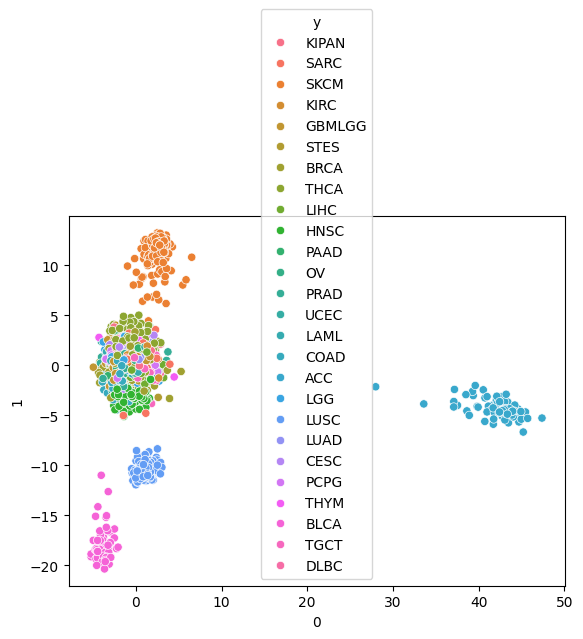

In [170]:
sns.scatterplot(x=0,y=1,hue = 'y', data=x_r4)

In [ ]:
lda

In [175]:
x_r4

,0,1,2,y
0,1.376800,0.413193,2.264831,KIPAN
1,-2.346093,-0.129749,1.809021,SARC
2,2.567573,12.976111,-13.446872,SKCM
3,-0.542099,1.545138,3.376228,KIRC
4,-1.767425,0.439230,1.284151,GBMLGG
...,...,...,...,...
6196,0.382200,0.583005,0.812467,LUAD
6197,-1.388121,0.538015,2.170654,LGG
6198,-1.637096,-0.041651,0.060793,COAD
6199,-0.146702,0.761188,2.386994,TGCT


In [226]:
x_r4[[0,'y']]

,0,y
0,1.376800,8
1,-2.346093,19
2,2.567573,20
3,-0.542099,9
4,-1.767425,6
...,...,...
6196,0.382200,13
6197,-1.388121,11
6198,-1.637096,4
6199,-0.146702,22


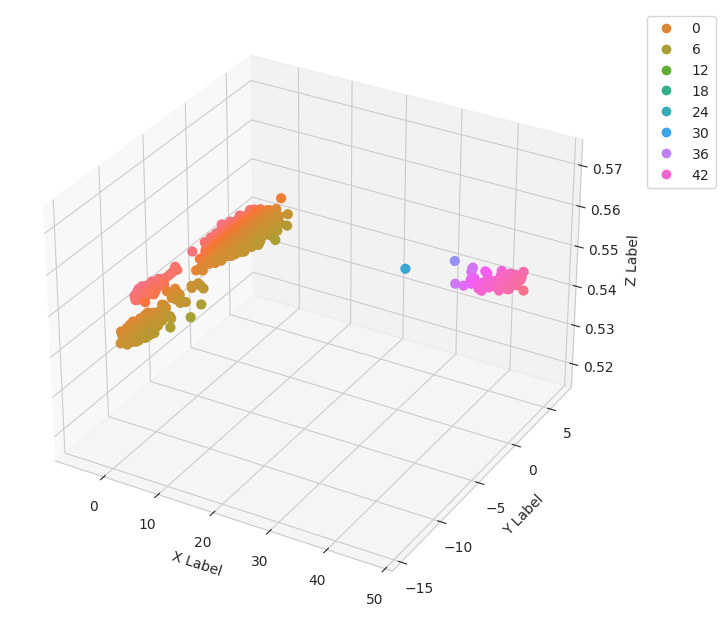

In [278]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
n = 200
x = x_r4[[0]]
y = x_r4[[1]]
y = x_r4[[2]]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)

fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=x, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [219]:
x_r4[1]

,1
0,0.413193
1,-0.129749
2,12.976111
3,1.545138
4,0.439230
...,...
6196,0.583005
6197,0.538015
6198,-0.041651
6199,0.761188


In [209]:
lle = LabelEncoder()
x_r4['y'] = lle.fit_transform(x_r4['y'])

In [243]:
df.y.unique()

array([ 8, 19, 20,  9,  6, 21,  2, 23, 12,  7, 16, 15, 18, 25, 10,  4,  0,
       11, 14, 13,  3, 17, 24,  1, 22,  5])

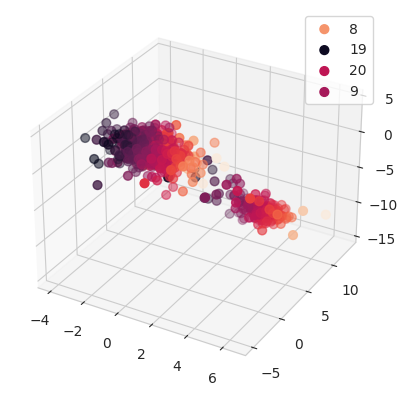

In [274]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

df = x_r4

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
i=0
for s in df.y.unique()[:4]:
  ax.scatter(xs=df[0][df.y==s], ys =df[1][df.y==s], zs=df[2][df.y==s], s=40, c=df[0][df.y==s], label=s)
  i+=1
ax.legend()

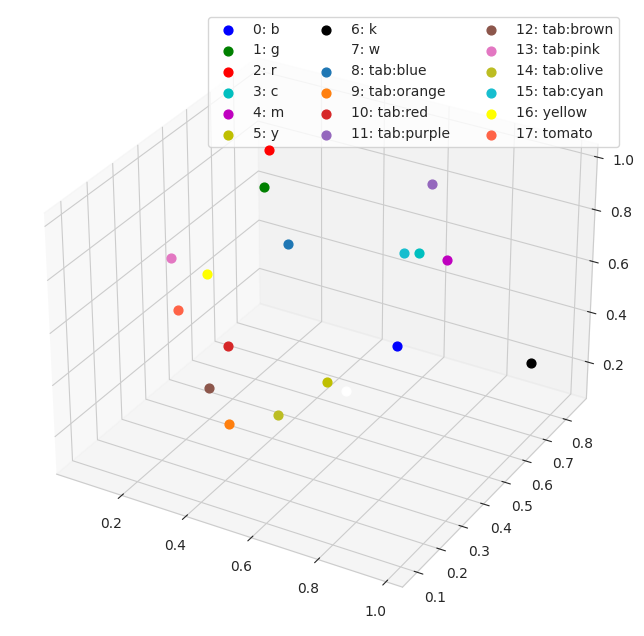

In [272]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#simulate your data
np.random.seed(123)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan', 'yellow', 'tomato']
df = pd.DataFrame({"Valence": np.random.random(len(colors)),
                   "Arousal": np.random.random(len(colors)),
                   "Dominance": np.random.random(len(colors)),
                   "colors": colors,
                   "Labels": [f"{i}: {c}" for i, c in enumerate(colors)]
                   })

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

for x, y, z, c, l in zip(df.Valence, df.Arousal, df.Dominance, df.colors, df.Labels):
    ax.scatter(xs=x, ys=y, zs=z, s=40, c=c, label=l)

ax.legend(ncol=3)
plt.grid(b=True)
plt.show()

In [273]:
df

,Valence,Arousal,Dominance,colors,Labels
0,0.696469,0.531551,0.426351,b,0: b
1,0.286139,0.531828,0.893389,g,1: g
2,0.226851,0.634401,0.944160,r,2: r
3,0.551315,0.849432,0.501837,c,3: c
4,0.719469,0.724455,0.623953,m,4: m
5,0.423106,0.611024,0.115618,y,5: y
6,0.980764,0.722443,0.317285,k,6: k
7,0.684830,0.322959,0.414826,w,7: w
8,0.480932,0.361789,0.866309,tab:blue,8: tab:blue
9,0.392118,0.228263,0.250455,tab:orange,9: tab:orange


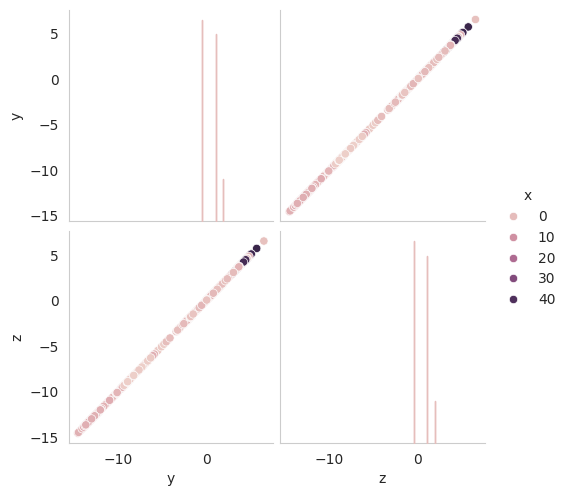

In [196]:
#Seaborn pair plot
df_3d = pd.DataFrame()
df_3d['x'] = x
df_3d['y'] = y
df_3d['z'] = z

sns.pairplot(df_3d, hue='x')

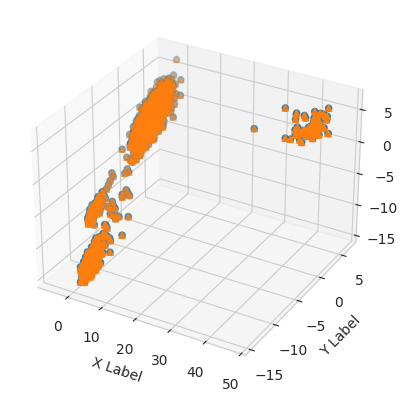

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for m, zlow, zhigh in [('o', -50, -25), ('^', -30, -5)]:
    xs = x#randrange(n, 23, 32)
    ys = y#randrange(n, 0, 100)
    zs = z#randrange(n, zlow, zhigh)
    ax.scatter(xs, ys, zs, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

<Figure size 600x600 with 0 Axes>

In [124]:
ml_x = x_lda
ml_y = y_lda
ml_x.shape,ml_y.shape
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(ml_x,ml_y,test_size=0.30,random_state=30)

In [125]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier(max_depth=5)
dt_clf.fit(x_train,y_train)
dt_clf.score(x_test,y_test)

y_pred=(dt_clf.predict(x_test))
dt_clf.score(x_test,y_test)


0.24449220849005912

In [126]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
sv_clf = SVC(probability=True, kernel='linear')
sv_clf.fit(x_train,y_train)
sv_clf.score(x_test,y_test)


y_pred = sv_clf.predict(x_test)
print(accuracy_score(y_test,y_pred))


0.3245566899516389


In [128]:
from sklearn import ensemble
rf_clf = ensemble.RandomForestClassifier(n_estimators=100)
rf_clf.fit(x_train,y_train)
rf_clf.score(x_test,y_test)

0.29285330467490595

In [127]:
from sklearn.naive_bayes import GaussianNB
gb_clf = GaussianNB()
gb_clf.fit(x_train,y_train)
gb_clf.score(x_test,y_test)

0.09027404621171413

In [129]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(x_train,y_train)
knn_clf.score(x_test,y_test)


0.13164965072541646

In [130]:
# automatically select the number of features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# create pipeline
rfe = RFECV(estimator=DecisionTreeClassifier())
model = DecisionTreeClassifier()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.887 (0.025)


In [133]:
df_tsne_data = data.copy()
non_numeric = ['SUBCLASS']
df_tsne_data = df_tsne_data.drop(non_numeric, axis=1)
df_tsne_data

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
#import T-SNE from sklearn
from sklearn.manifold import TSNE
m = TSNE(learning_rate=50)
tnse_features = m.fit_transform(df_tsne_data)
tnse_features[1:4,:]

array([[ 11.522288 ,  -3.2656548],
       [-18.370792 ,  -1.3636229],
       [ -9.118988 , -14.100624 ]], dtype=float32)

In [135]:
df_tsne = pd.DataFrame(data=tnse_features,columns=['tsne1','tsne2'])
df_tsne['cancer_type']=data['SUBCLASS']
df_tsne

,tsne1,tsne2,cancer_type
0,-2.034272,-1.304612,KIPAN
1,11.522288,-3.265655,SARC
2,-18.370792,-1.363623,SKCM
3,-9.118988,-14.100624,KIRC
4,10.165175,6.833542,GBMLGG
...,...,...,...
6196,-15.284212,-12.581932,LUAD
6197,4.505183,22.456762,LGG
6198,26.666481,42.412449,COAD
6199,46.810425,8.175353,TGCT


In [136]:
df_anova_tsne = df_tsne[['tsne2','cancer_type']]
grps_tsne = pd.unique(df_anova_tsne.cancer_type.values)

d_data = {grp:df_anova_tsne['tsne2'][df_anova_tsne.cancer_type == grp] for grp in grps_tsne}

F, p = stats.f_oneway(d_data['LUAD'], d_data['PRAD'], d_data['BRCA'], d_data['KIRC'], d_data['COAD'])

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")


reject null hypothesis


In [137]:
df_anova_tsne = df_tsne[['tsne1','cancer_type']]
grps_tsne = pd.unique(df_anova_tsne.cancer_type.values)

d_data = {grp:df_anova_tsne['tsne1'][df_anova_tsne.cancer_type == grp] for grp in grps_tsne}

F, p = stats.f_oneway(d_data['LUAD'], d_data['PRAD'], d_data['BRCA'], d_data['KIRC'], d_data['COAD'])

if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

reject null hypothesis


https://www.kaggle.com/code/prashanthsheri/icmr-healthcare-cancer-type-and-gene-analysis/notebook

In [138]:

features=data.drop(['SUBCLASS'],axis=1)
target=data['SUBCLASS']
features.head()

,A2M,AAAS,AADAT,AARS1,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF292,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
f1=features.values

In [140]:
y1 = pd.get_dummies(y_lda)

In [327]:
y_lda

,SUBCLASS
0,KIPAN
1,SARC
2,SKCM
3,KIRC
4,GBMLGG
...,...
6196,LUAD
6197,LGG
6198,COAD
6199,TGCT


In [141]:
from sklearn.model_selection import train_test_split

#y1 = pd.get_dummies(Xg_fea.Pos_Neg)

X1_train, X1_valid, y1_train, y1_valid = train_test_split(f1,y1, test_size = 0.10, random_state=42)

In [142]:
X1_train.shape,X1_valid.shape,y1_valid.shape,y1_train.shape

((5580, 4358), (621, 4358), (621, 26), (5580, 26))

In [143]:
import tensorflow as tf

In [148]:
model = tf.keras.models.Sequential()

#adding layers of inout
model.add(tf.keras.layers.Dense(10000, input_dim=4358, activation='relu', kernel_initializer='he_uniform'))


#Normalize the data
model.add(tf.keras.layers.BatchNormalization())

#Add 1st hidden layer
model.add(tf.keras.layers.Dense(5000, activation='relu'))

#Add 2nd hidden layer
model.add(tf.keras.layers.Dense(2000, activation='relu'))

#Add 3rd hidden layer
model.add(tf.keras.layers.Dense(1000, activation='relu'))

#Add 4th hidden layer
model.add(tf.keras.layers.Dense(500, activation='relu'))

#Add 5th hidden layer
model.add(tf.keras.layers.Dense(200, activation='relu'))

#Add 6th hidden layer
model.add(tf.keras.layers.Dense(100, activation='relu'))

#Add OUTPUT layer
model.add(tf.keras.layers.Dense(26, activation='softmax'))

#Create optimizer with non-default learning rate
sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.03)

#Compile the model
model.compile(optimizer=sgd_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [149]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 10000)               │      43,590,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10000)               │          40,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 5000)                │      50,005,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 2000)                │      10,002,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1000)                │       2,001,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 500)                 │         500,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 200)                 │         100,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 26)                  │           2,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,261,426 (405.36 MB)

 Trainable params: 106,241,426 (405.28 MB)

 Non-trainable params: 20,000 (78.12 KB)

In [150]:
history = model.fit(X1_train, y1_train,
          validation_data=(X1_valid,y1_valid),
          epochs=5,
          batch_size=32)

Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 117s 659ms/step - accuracy: 0.1601 - loss: 2.8731 - val_accuracy: 0.2448 - val_loss: 2.9319
Epoch 2/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 137s 632ms/step - accuracy: 0.4005 - loss: 1.8769 - val_accuracy: 0.3205 - val_loss: 2.3844
Epoch 3/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 140s 622ms/step - accuracy: 0.6530 - loss: 1.0496 - val_accuracy: 0.3575 - val_loss: 2.1819
Epoch 4/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 140s 609ms/step - accuracy: 0.8056 - loss: 0.5258 - val_accuracy: 0.2947 - val_loss: 2.8423
Epoch 5/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 142s 610ms/step - accuracy: 0.8731 - loss: 0.3261 - val_accuracy: 0.2818 - val_loss: 3.5296


In [151]:
xyz = model.predict(X1_valid)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


In [315]:
X1_valid

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [153]:
import numpy as np
y_pr=[]
for k in xyz:
    #np.argmax(k)
    #print(np.argmax(k))
    y_pr.append(np.argmax(k))

y_val=[]
for k in y1_valid.values:
    #np.argmax(k)
    #print(np.argmax(k))
    y_val.append(np.argmax(k))

In [154]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pr)


array([[ 1,  2,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  0,
         0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  4,  9,  0,  0,  0,  0,  2,  0,  0,  0,  0,  1,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 62,  1,  0,  0,  0,  1,  3,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 13,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  7,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  1],
       [ 0,  2,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  2,  0,  1, 13,  1,  1,  0,  0,
         0,  0,  2,  1,  1,  0,  1,  0,  1,  3],
       [ 0,  1,  9,  0,  0,  0,  0, 11,  0,  0,  0,  0,  1,  0,  2,  0,
         0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  9,  1,  0,  0, 

In [155]:
_, train_acc = model.evaluate(X1_train, y1_train, verbose=0)
_, test_acc = model.evaluate(X1_valid, y1_valid, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.799, Test: 0.282


In [316]:
xyz2= model.predict(df_test_01)
y_pr=[]
for k in xyz2:
    #np.argmax(k)
    #print(np.argmax(k))
    y_pr.append(np.argmax(k))



80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step


NameError: name 'y_pre' is not defined

In [329]:
result_df2= pd.DataFrame(y_pr, columns=y1.columns).idxmax(axis=1)

ValueError: Shape of passed values is (2546, 1), indices imply (2546, 26)

In [332]:
y_pr_converted = [y1.columns[idx] for idx in y_pr]

In [334]:

res_df34 = pd.DataFrame ({'ID' : df_test_raw['ID'], 'SUBCLASS' : y_pr_converted})
res_df34.to_csv('submission_DNN.csv', index=False)

In [333]:
y_pr_converted

['BRCA',
 'BLCA',
 'BRCA',
 'BRCA',
 'LUSC',
 'UCEC',
 'BRCA',
 'UCEC',
 'BRCA',
 'KIPAN',
 'KIPAN',
 'LAML',
 'STES',
 'STES',
 'KIPAN',
 'ACC',
 'BRCA',
 'THYM',
 'KIRC',
 'BRCA',
 'BRCA',
 'COAD',
 'LGG',
 'BRCA',
 'LUSC',
 'STES',
 'BRCA',
 'STES',
 'BRCA',
 'BRCA',
 'BRCA',
 'SKCM',
 'BRCA',
 'BRCA',
 'KIPAN',
 'STES',
 'GBMLGG',
 'BRCA',
 'BRCA',
 'BRCA',
 'BRCA',
 'BRCA',
 'SKCM',
 'UCEC',
 'BRCA',
 'BRCA',
 'KIPAN',
 'BRCA',
 'HNSC',
 'BRCA',
 'STES',
 'KIPAN',
 'BRCA',
 'LUSC',
 'STES',
 'LIHC',
 'STES',
 'BRCA',
 'KIPAN',
 'SKCM',
 'LIHC',
 'BRCA',
 'BRCA',
 'LIHC',
 'BRCA',
 'BLCA',
 'STES',
 'CESC',
 'BRCA',
 'BLCA',
 'CESC',
 'UCEC',
 'BRCA',
 'BRCA',
 'BRCA',
 'BRCA',
 'BRCA',
 'STES',
 'HNSC',
 'BRCA',
 'CESC',
 'BRCA',
 'LUSC',
 'BRCA',
 'STES',
 'BLCA',
 'SKCM',
 'BRCA',
 'LUSC',
 'BRCA',
 'THCA',
 'KIPAN',
 'CESC',
 'LIHC',
 'BRCA',
 'KIPAN',
 'STES',
 'UCEC',
 'STES',
 'BRCA',
 'BRCA',
 'KIPAN',
 'BRCA',
 'LGG',
 'BRCA',
 'CESC',
 'BRCA',
 'BRCA',
 'BLCA',
 'LUSC',
 

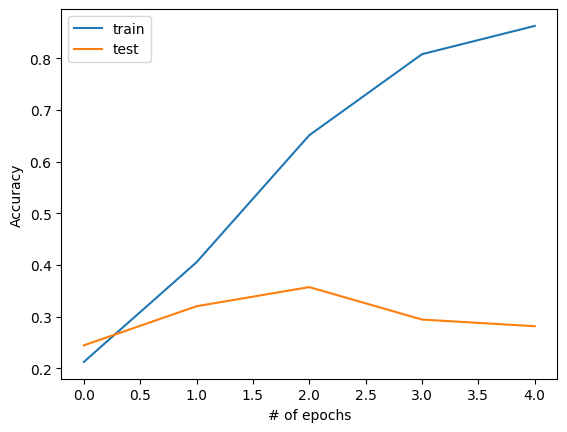

In [156]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('# of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
import scipy.stats as stats
def f_test(df_f_test,gene):
    df_anova = df_f_test[[gene,'SUBCLASS']]
    grps = pd.unique(df_anova.SUBCLASS.values)
    grps
    d_data = {grp:df_anova[gene][df_anova.SUBCLASS == grp] for grp in grps}
    F, p = stats.f_oneway(d_data['LUAD'], d_data['PRAD'], d_data['BRCA'], d_data['KIRC'], d_data['COAD'])
    print("p_values:-",p)
    if p<0.05:
        print("reject null hypothesis")
    else:
        print("accept null hypothesis")

    return

In [43]:
df_f_test.columns[1:]

Index(['A2M', 'AAAS', 'AADAT', 'AARS1', 'ABAT', 'ABCA1', 'ABCA2', 'ABCA3',
       'ABCA4', 'ABCA5',
       ...
       'ZNF292', 'ZNF365', 'ZNF639', 'ZNF707', 'ZNFX1', 'ZNRF4', 'ZPBP',
       'ZW10', 'ZWINT', 'ZYX'],
      dtype='object', length=4358)

In [36]:
f_test(df_f_test, "BRCA1")

p_values:- nan
accept null hypothesis


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


In [ ]:

# 모델 구성
model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(le.classes_), activation='softmax')  # 클래스 수에 맞추어 출력 노드 수 설정
])

# 모델 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val), epochs=100, batch_size=16, callbacks=[early_stopping])

# 테스트 데이터 예측
X_test_encoded = X_encoded[len(y_encoded):]  # 테스트 데이터 부분
X_test_scaled = scaler.transform(X_test_encoded)  # 정규화 적용

predictions = model.predict(X_test_scaled)

# 예측 결과 변환 (가장 높은 확률의 클래스를 선택)
predicted_classes = predictions.argmax(axis=1)

# 레이블 인코딩된 클래스를 원래 클래스 이름으로 변환
predicted_labels = le.inverse_transform(predicted_classes)

# 결과를 DataFrame으로 저장
results = pd.DataFrame({
    'ID': test_data['ID'],
    'Predicted_SUBCLASS': predicted_labels
})

# 결과를 CSV 파일로 저장
results.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'.")